# Selecting dimensionality reduction with Pipeline and GridSearchCV

This example constructs a pipeline that does dimensionality reduction followed by prediction with a support vector classifier. It demonstrates the use of GridSearchCV and Pipeline to optimize over different classes of estimators in a single CV run – unsupervised PCA and NMF dimensionality reductions are compared to univariate feature selection during the grid search.

Additionally, Pipeline can be instantiated with the memory argument to memoize the transformers within the pipeline, avoiding to fit again the same transformers over and over.

# 1. Load necessary libraries

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_digits
from sklearn.decomposition import NMF, PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC

# 2. Load the data and do initial analysis

In [49]:
X, y = load_digits(return_X_y=True)

In [50]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [51]:
pd.DataFrame(y).value_counts()

,count
0,
3,183
1,182
5,182
4,181
6,181
9,180
7,179
0,178
2,177


# 3. Pipeline design

In [52]:
pipe = Pipeline(
    [
        ("scaling", MinMaxScaler()),
        # the reduce_dim stage is populated by the param_grid
        ("reduce_dim", "passthrough"),
        ("classify", LinearSVC(dual=False, max_iter=10000)),
    ]
)

# 4. Initiate and execute grid search

In [54]:
N_FEATURES_OPTIONS = [2, 4, 8]
C_OPTIONS = [1, 10, 100, 1000]
param_grid = [
    {
        "reduce_dim": [PCA(iterated_power=7), NMF(max_iter=1_000)],
        "reduce_dim__n_components": N_FEATURES_OPTIONS,
        "classify__C": C_OPTIONS,
    },
    {
        "reduce_dim": [SelectKBest(mutual_info_classif)],
        "reduce_dim__k": N_FEATURES_OPTIONS,
        "classify__C": C_OPTIONS,
    },
]
reducer_labels = ["PCA", "NMF", "KBest(mutual_info_classif)"]

In [55]:
grid = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid)
grid.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('scaling', MinMaxScaler()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classify',
                                        LinearSVC(dual=False,
                                                  max_iter=10000))]),
             n_jobs=1,
             param_grid=[{'classify__C': [1, 10, 100, 1000],
                          'reduce_dim': [PCA(iterated_power=7),
                                         NMF(max_iter=1000)],
                          'reduce_dim__n_components': [2, 4, 8]},
                         {'classify__C': [1, 10, 100, 1000],
                          'reduce_dim': [SelectKBest(score_func=<function mutual_info_classif at 0x7ce93e5617e0>)],
                          'reduce_dim__k': [2, 4, 8]}])

In [56]:
grid.best_params_

{'classify__C': 1,
 'reduce_dim': PCA(iterated_power=7),
 'reduce_dim__n_components': 8}

# 5. Visualize the results

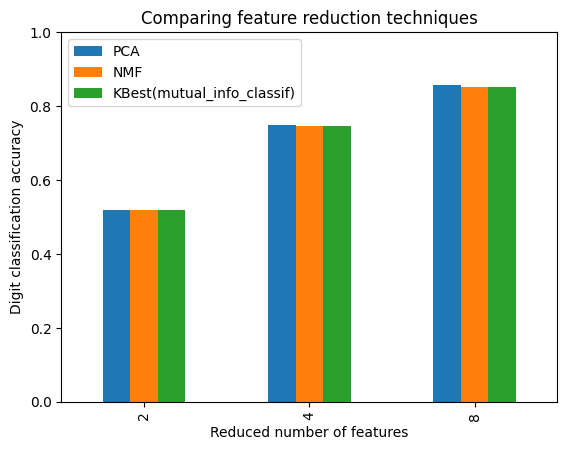

In [57]:
import pandas as pd

mean_scores = np.array(grid.cv_results_["mean_test_score"])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
# create a dataframe to ease plotting
mean_scores = pd.DataFrame(
    mean_scores.T, index=N_FEATURES_OPTIONS, columns=reducer_labels
)

ax = mean_scores.plot.bar()
ax.set_title("Comparing feature reduction techniques")
ax.set_xlabel("Reduced number of features")
ax.set_ylabel("Digit classification accuracy")
ax.set_ylim((0, 1))
ax.legend(loc="upper left")

plt.show()